# `AA Workshop 6` — Coding Challenge

Complete the tasks below to practice implementing regression modeling from `W6_Regression_Advanced.ipynb`.

Guidelines:
- Work in order. Run each cell after editing with Shift+Enter.
- Keep answers short; focus on making things work.
- If a step fails, read the error and fix it.

By the end you will have exercised:
- implementing linear regression modelling with polynomial features
- implementing L1 & L2 regularization
- evaluating using proper cross-validation

## Task 1 - Predicting Shared Bike Demand in Seoul

You have been provided with a dataset (`SeoulBikeData.csv` in the `data` directory) that contains counts of public bicycles rented per hour in the Seoul Bike Sharing System, with corresponding weather data and holiday information. The dataset is publicly available and you can find further information [here](https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand). Your task is to predict the hourly count of shared bikes based on temperature. Do the following:
- Load and inspect the data; perform any clearning steps if necessary.
- Define and create a scatter plot of x and y.
- Perform a train-holdout-test split.
- Train simple, Ridge, and Lasso regression models with polynomial degrees from 1 to 5 and alphas of 0.01, 0.1, 1, 10 (for Ridge and Lasso). Tune hyperparameters based on holdout performance, select the best performing model based on the mean squared error, and calculate final performance on the test set.
- Create a scatter plot of the true values and predictions of the best performing model.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# load and inspect data
data = pd.read_csv("../data/SeoulBikeData.csv")

data.head()

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [2]:
# filter out out-of-service observations
data = data[data["Functioning Day"] == "Yes"].copy()

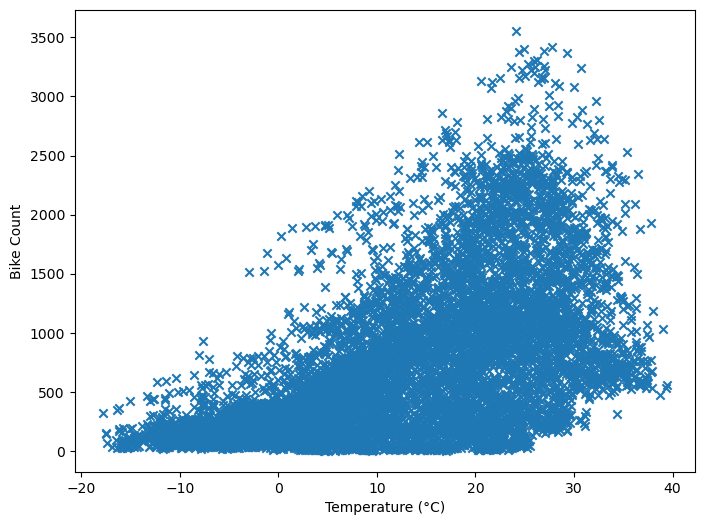

In [3]:
# define and plot x and y
x = data["Temperature(C)"].values.reshape((-1,1)) # remember: if we pass a 1-feature array we need to re-shape it!
y = data["Rented Bike Count"]

plt.figure(figsize = (8,6))
plt.scatter(x, y, marker="x")
plt.xlabel("Temperature (°C)")
plt.ylabel("Bike Count")
plt.show()

In [4]:
# perform train-holdout-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1)
x_train, x_hold, y_train, y_hold = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state=1)

print(len(x_train), len(x_hold), len(x_test))

4232 1693 2540


In [5]:
# configure model search
degrees = range(1, 6)
alphas = [0.01, 0.1, 1, 10]
models = ["linear", "Ridge", "Lasso"]
results = []

In [6]:
for model in models:
    for degree in degrees:
        # create polynomial features
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_train_poly = poly.fit_transform(x_train)
        X_hold_poly = poly.transform(x_hold)

        # standardize
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_poly)
        X_hold_scaled = scaler.transform(X_hold_poly)

        # for Ridge or Lasso, loop over alphas
        if model in ["Ridge", "Lasso"]:
            for alpha in alphas:
                # initialize
                if model == "Ridge":
                    reg = Ridge(alpha=alpha)
                else:
                    reg = Lasso(alpha=alpha, max_iter=10000)

                # fit
                reg.fit(X_train_scaled, y_train)

                # predict on validation and calculate error
                y_hold_pred = reg.predict(X_hold_scaled)
                mse_val = mean_squared_error(y_hold, y_hold_pred)

                results.append({
                    "model": model,
                    "degree": degree,
                    "alpha": alpha,
                    "mse": mse_val,
                    "poly": poly,
                    "scaler": scaler,
                    "reg": reg
                })

        # linear regression without regularization
        else:
            # initialize
            reg = LinearRegression()

            # fit
            reg.fit(X_train_scaled, y_train)

            # predict on validation and calculate error
            y_hold_pred = reg.predict(X_hold_scaled)
            mse_val = mean_squared_error(y_hold, y_hold_pred)

            results.append({
                "model": model,
                "degree": degree,
                "alpha": None,
                "mse": mse_val,
                "poly": poly,
                "scaler": scaler,
                "reg": reg
            })

results = pd.DataFrame(results)

results

,model,degree,alpha,mse,poly,scaler,reg
0,linear,1,NaN,279502.576578,"PolynomialFeatures(degree=1, include_bias=False)",StandardScaler(),LinearRegression()
1,linear,2,NaN,279198.811947,PolynomialFeatures(include_bias=False),StandardScaler(),LinearRegression()
2,linear,3,NaN,269715.476914,"PolynomialFeatures(degree=3, include_bias=False)",StandardScaler(),LinearRegression()
3,linear,4,NaN,268466.109542,"PolynomialFeatures(degree=4, include_bias=False)",StandardScaler(),LinearRegression()
4,linear,5,NaN,268352.750538,"PolynomialFeatures(degree=5, include_bias=False)",StandardScaler(),LinearRegression()
5,Ridge,1,0.01,279502.576595,"PolynomialFeatures(degree=1, include_bias=False)",StandardScaler(),Ridge(alpha=0.01)
6,Ridge,1,0.10,279502.576811,"PolynomialFeatures(degree=1, include_bias=False)",StandardScaler(),Ridge(alpha=0.1)
7,Ridge,1,1.00,279502.585548,"PolynomialFeatures(degree=1, include_bias=False)",StandardScaler(),Ridge(alpha=1)
8,Ridge,1,10.00,279503.327927,"PolynomialFeatures(degree=1, include_bias=False)",StandardScaler(),Ridge(alpha=10)
9,Ridge,2,0.01,279198.818890,PolynomialFeatures(include_bias=False),StandardScaler(),Ridge(alpha=0.01)


In [7]:
# select best model
best_idx = results["mse"].idxmin()
best_model = results.loc[best_idx]

print(best_model)

model                                                Ridge
degree                                                   5
alpha                                                  1.0
mse                                          268351.220435
poly      PolynomialFeatures(degree=5, include_bias=False)
scaler                                    StandardScaler()
reg                                         Ridge(alpha=1)
Name: 23, dtype: object


In [8]:
# evaluate on test set
## extract best model components
best_poly = best_model["poly"]
best_scaler = best_model["scaler"]
best_reg = best_model["reg"]

## transform test set
X_test_poly = best_poly.transform(x_test)
X_test_scaled = best_scaler.transform(X_test_poly)

## predict
y_test_pred = best_reg.predict(X_test_scaled)

## evaluate
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("\nTest MSE:", mse_test)
print("Test R2:", r2_test)


Test MSE: 272102.069310991
Test R2: 0.34569322517852297


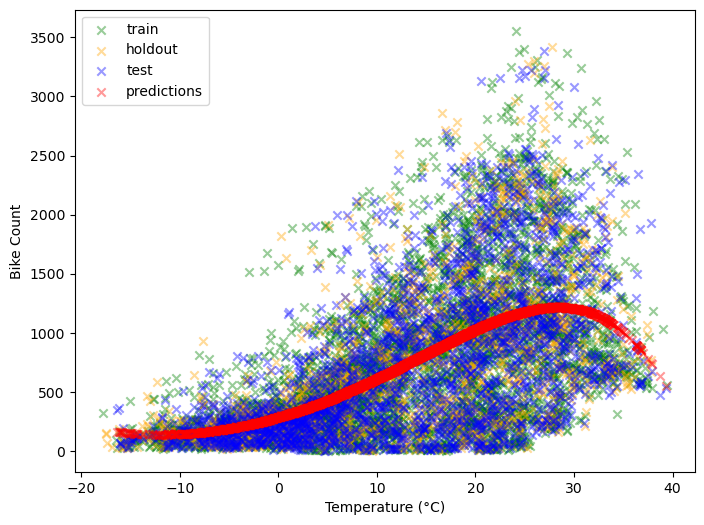

In [9]:
# plot
plt.figure(figsize = (8,6))
plt.scatter(x_train, y_train, marker="x", alpha=0.4, color="green", label="train")
plt.scatter(x_hold, y_hold, marker="x", alpha=0.4, color="orange", label="holdout")
plt.scatter(x_test, y_test, marker="x", alpha=0.4, color="blue", label="test")
plt.scatter(x_test, y_test_pred, marker="x", alpha=0.4, color="red", label="predictions")
plt.xlabel("Temperature (°C)")
plt.ylabel("Bike Count")
plt.legend()
plt.show()

---